In [17]:
%matplotlib inline

In [18]:
%run /Users/ekoch/Dropbox/observing_code/SMA/sma-otf-scripts/sensitivity_time_functions.py

In [19]:
dist_m31 = 0.77 * u.Mpc

Mass sensitivity goals set by ensuring we can detect relatively low-mass GMCs in the Solar neighborhood:

In [ ]:
# Lowe mass clouds:
# Perseus 2e4 Msol
# Taurus/Ophiuchus 1.2e4 Msol

# perseus_mass = 2e4 * u.solMass


# Revise to go a bit deeper and be able to detect Taurus in 1 beam
taurus_mass = 1.2e4 * u.solMass


taurus_mass

<Quantity 12000. solMass>

Target is $5\sigma$ detection at this H2 mass per beam:

In [21]:
mass_target = taurus_mass

sigma_mass = mass_target / 5.

sigma_mass

<Quantity 2400. solMass>

In [22]:
co_intint = h2mass_to_co_brightness(sigma_mass,
                            alpha_CO=4.35*(u.solMass / u.pc**2) / (u.K * u.km / u.s),
                            R21=R21_l22,
                            R32=R32_l22,
                            distance=dist_m31,
                            beam_size=4*u.arcsec,
                            to_jy=True,
                            )

co_intint

{'CO10': <Quantity 0.38329924 Jy km / s>,
 'CO21': <Quantity 0.99654345 Jy km / s>,
 'CO32': <Quantity 1.12104005 Jy km / s>}

In [23]:
co_intint_k = h2mass_to_co_brightness(sigma_mass,
                            alpha_CO=4.35*(u.solMass / u.pc**2) / (u.K * u.km / u.s),
                            R21=R21_l22,
                            R32=R32_l22,
                            distance=dist_m31,
                            beam_size=4*u.arcsec,
                            to_jy=False,
                            )

co_intint_k

{'CO10': <Quantity 2.20339231 K km / s>,
 'CO21': <Quantity 1.432205 K km / s>,
 'CO32': <Quantity 0.7161025 K km / s>}

In [24]:
target_rms_intint = co_intint['CO21']

target_rms_intint

<Quantity 0.99654345 Jy km / s>

Assume typical line width to be 5 km/s. Use this to estimate peak sensitivity per channel.

In [25]:
linewidth = 5 * u.km / u.s

In [26]:
target_rms_peak = target_rms_intint / linewidth

target_rms_peak

<Quantity 0.19930869 Jy>

In [27]:
print(co_intint_k['CO10'] / linewidth)
print(co_intint_k['CO21'] / linewidth)
print(co_intint_k['CO32'] / linewidth)


0.440678462166753 K
0.28644100040838943 K
0.14322050020419472 K


In [28]:
target_rms_peak.to(u.mJy)

<Quantity 199.30868938 mJy>

# Mapping speed and total time estimates

Now incorporate the mapping speed:

Following the OTF time guide from the VLA here: https://science.nrao.edu/facilities/vla/docs/manuals/obsguide/modes/mosaicking

Use time above elevation limits appropriate for early October as time available for mapping + gain cal.

In [29]:

# Based on visibility on 10/02
time_per_track = 10.75 * u.hr  # el > 18
time_per_track_com = 10.75 * u.hr  # el > 18
time_per_track_sub = 8.5 * u.hr  # el > 32

Implements mapping times with OTF overheads (from Attila) with adjustable mapping speeds, dump times, time on gains and time per gain loop.

In [30]:
%run /Users/ekoch/Dropbox/observing_code/SMA/sma-otf-scripts/otf_map_functions.py


## SUB+COM with 8 antennas

We assume 8 antennas time calcs, though expect 6-7 antennas will be avavilable during the wSMA upgrades.

SUB

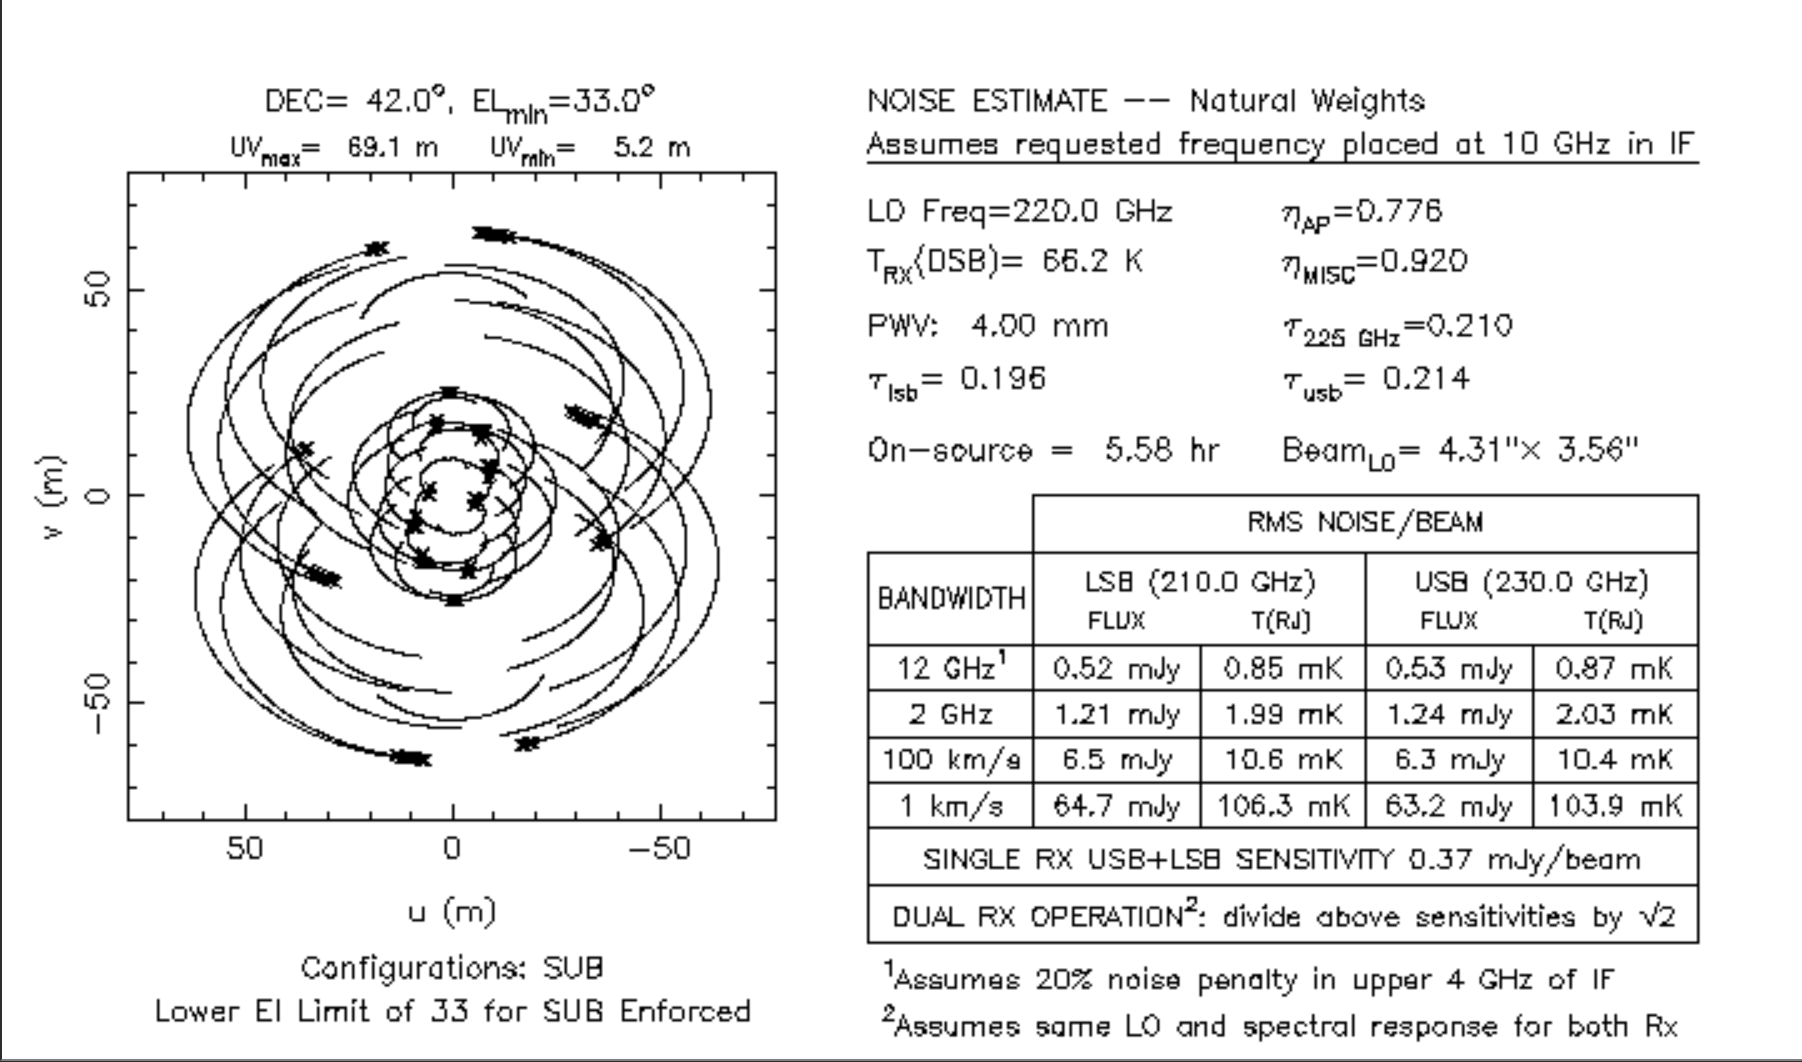


COM

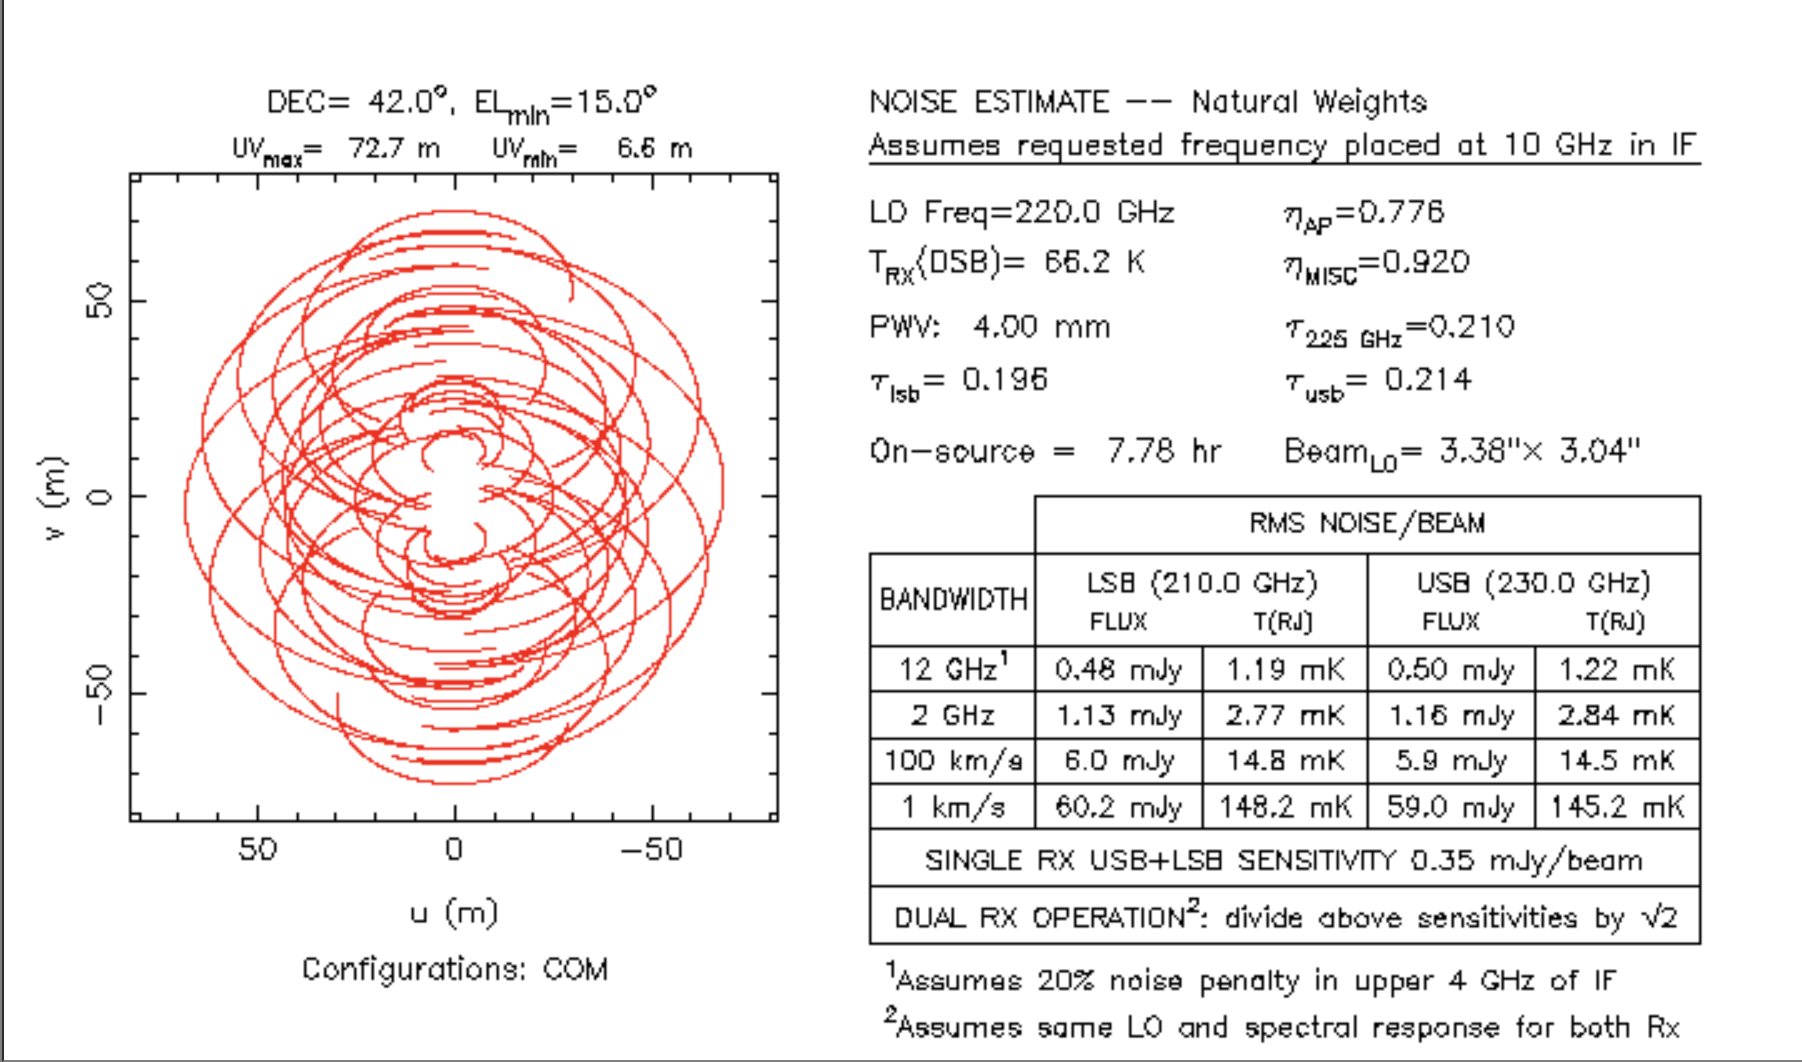


Estimate time on source needed by scaling from the per track time. Provides some accounting for varying elevations (as we plan to do several snapshots through a track, we should sample at a range of elevations per beam).

In [31]:
time_onsource_calc_ideal_com = 7.78 * u.hr
time_onsource_calc_ideal_sub = 5.58 * u.hr

print(time_onsource_calc_ideal_com + time_onsource_calc_ideal_sub)

sub_com_ratio = time_onsource_calc_ideal_sub / time_onsource_calc_ideal_com
print(sub_com_ratio)

# dual rx normalized by 5 km/s channel.
rms_calc_ideal_com = 59 * u.mJy / np.sqrt(2) / np.sqrt(linewidth.value)

# Multiply the target rms by 1.2 to account for baseline overlap with SUB and with our target beam being closer to 4" not 3".
target_rms_peak_com = target_rms_peak * 1.2
print(target_rms_peak_com.to(u.mJy))

time_on_source_needed_ideal_com = time_onsource_calc_ideal_com.to(u.min) * (rms_calc_ideal_com / target_rms_peak_com.to(u.mJy))**2

time_on_source_needed_ideal_com


13.36 h
0.7172236503856041
239.17042726190374 mJy


<Quantity 2.84066429 min>

In [32]:
rms_calc_ideal_com

<Quantity 18.65743819 mJy>

In [33]:
# dual rx normalized by 5 km/s channel.
rms_calc_ideal_sub = 63.2 * u.mJy / np.sqrt(2) / np.sqrt(linewidth.value)

# Multiply the target rms by 1.2 to account for baseline overlap with SUB and with our target beam being closer to 4" not 3".
target_rms_peak_sub = target_rms_peak * 1.2
print(target_rms_peak_sub.to(u.mJy))

time_on_source_needed_ideal_sub = time_onsource_calc_ideal_sub.to(u.min) * (rms_calc_ideal_sub / target_rms_peak_sub.to(u.mJy))**2

time_on_source_needed_ideal_sub

239.17042726190374 mJy


<Quantity 2.33778543 min>

In [34]:
rms_calc_ideal_sub

<Quantity 19.98559481 mJy>

In [35]:
time_on_source_needed_ideal_total = time_on_source_needed_ideal_sub + time_on_source_needed_ideal_com

time_on_source_needed_ideal_total

<Quantity 5.17844972 min>

## OTF mapping calculations

Maximum sub-region size that we can use the interleaving approach is 14' x 8.5' within a 15 min gain loop.

We interleaved half takes 1 gain loop.

Assume 1.5 min for gain loop using the >1 Jy 0136+478 as the gain to max. efficiency.

### OTF in COM

In [50]:

row_length = 14 * u.arcmin
row_width = 9 * u.arcmin

m31_onemap_com_ideal_otf = otf_mapping_params(row_length, row_width,
                       time_per_track=time_per_track_com,
                       theta_pb=55*u.arcsec,
                       time_per_beam=time_on_source_needed_ideal_com,
                       t_dump=0.6*u.s,
                       beam_per_dump=0.125,
                       t_loop=15*u.min,
                       t_gain=1.5*u.min,
                      )
# Splitting into 2 interleaved halves. Match 1/2 total map time to 12 min
# so each full map is 30 min with 3 min per gains per 15 min loop.
print(f"Full map: {m31_onemap_com_ideal_otf['t_otf_map']}")
print(f"Half map: {m31_onemap_com_ideal_otf['t_otf_map']/2.}")

row_length 14.0 arcmin
row_width 9.0 arcmin
total_area 126.0 arcmin2
beam_area 0.47601736111111104 arcmin2
N_eff 264.6962281079268
time_all_beams 12.53188538526026 h
time_per_beam 2.8406642908754702 min
theta_row 27.5 arcsec
N_beam_row 15.272727272727272
R_target 11.458333333333334 arcsec / s
t_row 1.2218181818181817 min
Nrow 22.0
t_otf_map 28.763333333333335 min
N_otf_maps 26.141376397576156
N_gain 3.0
t_otf_map_total 0.5543888888888889 h
t_total_mapping_time 14.492488615078472 h
N_tracks 1.3481384758212531
maps_per_track 20.027616216169676
Full map: 28.763333333333335 min
Half map: 14.381666666666668 min


### OTF in SUB

In [51]:

row_length = 14 * u.arcmin
row_width = 9 * u.arcmin

m31_onemap_sub_ideal_otf = otf_mapping_params(row_length, row_width,
                       time_per_track=time_per_track_sub,
                       theta_pb=55*u.arcsec,
                       time_per_beam=time_on_source_needed_ideal_sub,
                       t_dump=0.6*u.s,
                       beam_per_dump=0.125,
                       t_loop=15*u.min,
                       t_gain=1.5*u.min,
                      )
# Splitting into 2 interleaved halves. Match 1/2 total map time to 12 min
# so each full map is 30 min with 3 min per gains per 15 min loop.
print(f"Full map: {m31_onemap_sub_ideal_otf['t_otf_map']}")
print(f"Half map: {m31_onemap_sub_ideal_otf['t_otf_map']/2.}")

row_length 14.0 arcmin
row_width 9.0 arcmin
total_area 126.0 arcmin2
beam_area 0.47601736111111104 arcmin2
N_eff 264.6962281079268
time_all_beams 10.313383079841374 h
time_per_beam 2.3377854275209873 min
theta_row 27.5 arcsec
N_beam_row 15.272727272727272
R_target 11.458333333333334 arcsec / s
t_row 1.2218181818181817 min
Nrow 22.0
t_otf_map 28.763333333333335 min
N_otf_maps 21.51360475572427
N_gain 3.0
t_otf_map_total 0.5543888888888889 h
t_total_mapping_time 11.926903436520695 h
N_tracks 1.4031651101789053
maps_per_track 15.678839104825641
Full map: 28.763333333333335 min
Half map: 14.381666666666668 min


Account for number of chunks in the total mosaic. Note the non-integer number of maps will end up being 24 with some small overlap between chunks to ensure uniform sensitivity between chunks.

In [38]:
row_length = 14 * u.arcmin
row_width = 8.5 * u.arcmin

per_map_area = row_length * row_width

# Main box
rect_length = 108 * u.arcmin
rect_width = 25.5 * u.arcmin

# rect_length = 112 * u.arcmin
# rect_width = 27 * u.arcmin

main_area = rect_length * rect_width

total_map_area = main_area

total_map_area.to(u.deg**2)

<Quantity 0.765 deg2>

In [39]:
print(f"Maps in Main Area: {main_area / per_map_area}")
Nmaps = main_area / per_map_area

# Final number accounting for overlap and edges at major axis extents:
Nmaps = 22

print(f"Final number of Maps: {Nmaps}")

Maps in Main Area: 23.142857142857142
Final number of Maps: 22


Including the gain overhead, the number of tracks needed is:

In [40]:
com_tracks_num = m31_onemap_com_ideal_otf['N_tracks'] * Nmaps

com_tracks_num

<Quantity 29.65904647>

In [41]:
sub_tracks_num = m31_onemap_sub_ideal_otf['N_tracks'] * Nmaps

sub_tracks_num

<Quantity 30.86963242>

In [42]:
# Tracks for sub-"chunks" to be observed together:
m31_onemap_sub_ideal_otf['N_tracks'] * 6

<Quantity 8.41899066>

In [43]:
m31_onemap_sub_ideal_otf['N_tracks'] * 5

<Quantity 7.01582555>

In [44]:
total_tracks = com_tracks_num + sub_tracks_num

total_tracks

<Quantity 60.52867889>

## Number of maps per track

Estimate the number of chunks that we can map within 1 track.

Current proposed strategy is to observe in groups of 8 until full sensitivity is reached (with permutations in ordering to achieve optimal uv-coverage).

In [45]:
time_per_otf = m31_onemap_sub_ideal_otf['t_otf_map_total']

print(f"Maps per COM track: {time_onsource_calc_ideal_com / time_per_otf}")
print(f"Maps per SUB track: {time_onsource_calc_ideal_sub / time_per_otf}")

print(f"Max Map Fraction per COM track: {time_onsource_calc_ideal_com / time_per_otf / Nmaps}")
print(f"Max Map Fraction per SUB track: {time_onsource_calc_ideal_sub / time_per_otf / Nmaps}")

Maps per COM track: 14.033470287603969
Maps per SUB track: 10.06513678725323
Max Map Fraction per COM track: 0.6378850130729077
Max Map Fraction per SUB track: 0.45750621760241955



### Total time on source


Calculate on-source time from the time per beam multiplied by the effective number of beam in the square chunk size. Then multiple by the total number of maps (~23).

In [46]:
com_time_on_source = m31_onemap_com_ideal_otf['time_all_beams'] * Nmaps

com_time_on_source

<Quantity 275.70147848 h>

In [47]:
sub_time_on_source = m31_onemap_sub_ideal_otf['time_all_beams'] * Nmaps

sub_time_on_source

<Quantity 226.89442776 h>

In [48]:
com_time_on_source + sub_time_on_source

<Quantity 502.59590623 h>

#### Continuum sensitivity

In [49]:
bandwidth_factor = (22 / 16.)  # assume 40% higher sensitivity in chunks 5/6

# Now this assumes uniform sensitivity over chunks 5/6 so is on the optimistic side.
# Though it's not the primary target/output here
rms_cont = 0.37 * u.mJy / np.sqrt(2) / np.sqrt(bandwidth_factor)

rms_cont_on_source = rms_cont * np.sqrt((time_per_track_com.to(u.min) / time_on_source_needed_ideal_com)).to(u.one)

rms_cont_on_source

<Quantity 3.3620586 mJy>